Load data

In [6]:
import pandas as pd

In [7]:
data = pd.read_csv('application_train.csv')
data.sample()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
107261,224449,0,Cash loans,F,Y,Y,1,180000.0,314100.0,21375.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


In [8]:
data.shape

(307511, 122)

In [9]:
data.TARGET.value_counts()

0    282686
1     24825
Name: TARGET, dtype: int64

So we have unbalanced data.  Should we be careful with different algorithms?   

## Preprocessing

In [11]:
import numpy as np

In [12]:
values = [np.nan if val == 365243 else val for val in data['DAYS_EMPLOYED']]
data['DAYS_EMPLOYED'] = values

In [93]:
data = data.drop('SK_ID_CURR', axis=1)

It's a little painful to type (and read) the column names in UPPER CASE.  Let's make them lowercase. 

In [94]:
df = data.copy()
df = df.rename(columns=lambda x: x.lower())
df.sample()

,target,name_contract_type,code_gender,flag_own_car,flag_own_realty,cnt_children,amt_income_total,amt_credit,amt_annuity,amt_goods_price,...,flag_document_18,flag_document_19,flag_document_20,flag_document_21,amt_req_credit_bureau_hour,amt_req_credit_bureau_day,amt_req_credit_bureau_week,amt_req_credit_bureau_mon,amt_req_credit_bureau_qrt,amt_req_credit_bureau_year
90846,0,Cash loans,F,N,Y,0,128250.0,634482.0,20596.5,454500.0,...,0,0,0,0,0.0,0.0,0.0,0.0,1.0,0.0


### Imputing missing values

We know apriori that there are null values in the entries.  Let us just find out which coulms contain any null value. 

In [95]:
has_null = [col for col in df.columns 
            if sum(df[col].isnull())]

len(has_null)

68

We have to impute the missing (null) values.  However, the imputation strategy may be different based on the datatype.  Let's find which missing columns are numerical and which are categorical. 

In [96]:
has_null_num = [col for col in has_null 
                if df[col].dtype == 'float']

len(has_null_num)

62

In [97]:
has_null_cat = [col for col in has_null 
                if df[col].dtype == 'object']

len(has_null_cat)

6

Looks like `61` missing-value columns are numerical and `6` missing-value columns are categorical.  For simplicity we shall replace the missing values of a numerical column by the mean of that column.  We shall address the categorical columns individually.  Before we move on though, we whould be wary of missing values in the target column.  Let's see if there are any.  

In [98]:
'target' in has_null

False

#### Continuous

Now fill in the missing values with means.  

In [99]:
for col in has_null_num:
    df[col] = df[col].fillna(df[col].mean())

Let's check if we have any more null values.  

In [100]:
has_null_num = [col for col in df.columns 
                if (sum(df[col].isnull()) 
                    and df[col].dtype == 'float')]

len(has_null_num)

0

#### Discrete/categorical

In [101]:
has_null_cat

['name_type_suite',
 'occupation_type',
 'fondkapremont_mode',
 'housetype_mode',
 'wallsmaterial_mode',
 'emergencystate_mode']

In [102]:
df[has_null_cat].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Data columns (total 6 columns):
name_type_suite        306219 non-null object
occupation_type        211120 non-null object
fondkapremont_mode     97216 non-null object
housetype_mode         153214 non-null object
wallsmaterial_mode     151170 non-null object
emergencystate_mode    161756 non-null object
dtypes: object(6)
memory usage: 14.1+ MB


In [103]:
for col in has_null_cat:
    df[col] = df[col].fillna('unknown_'+col)

Let's see if there is any null entry any more.  

In [104]:
has_null = [col for col in df.columns 
            if sum(df[col].isnull())]

len(has_null)

0

### Vectorizing categorical variables

In [105]:
col_cat = [col for col in df.columns 
           
           if df[col].dtype == 'object']

In [106]:
len(col_cat)

16

In [107]:
for col in col_cat:
    dummy = pd.get_dummies(df[col], 
                           prefix=col, 
                           drop_first=True)    
    df = df.join(dummy)
    
df.shape

(307511, 251)

### Subsampling

In [108]:
df['target'].value_counts()

0    282686
1     24825
Name: target, dtype: int64

In [109]:
df_0 = df[df['target'] == 0]
df_1 = df[df['target'] == 1]
df_0.shape, df_1.shape

((282686, 251), (24825, 251))

In [110]:
df_0_sub = df_0.sample(df_1.shape[0])
df_0_sub.shape

(24825, 251)

In [111]:
df_sub = df_0_sub.append(df_1)

In [112]:
df_sub.shape

(49650, 251)

In [113]:
X = df_sub.drop(col_cat+['target'], axis=1)
y = df_sub['target']
X.shape, y.shape

((49650, 234), (49650,))

In [114]:
(y != df_sub['target']).sum()

0

In [115]:
X.sample()

,cnt_children,amt_income_total,amt_credit,amt_annuity,amt_goods_price,region_population_relative,days_birth,days_employed,days_registration,days_id_publish,...,housetype_mode_unknown_housetype_mode,wallsmaterial_mode_Mixed,wallsmaterial_mode_Monolithic,wallsmaterial_mode_Others,wallsmaterial_mode_Panel,"wallsmaterial_mode_Stone, brick",wallsmaterial_mode_Wooden,wallsmaterial_mode_unknown_wallsmaterial_mode,emergencystate_mode_Yes,emergencystate_mode_unknown_emergencystate_mode
125639,2,180000.0,314100.0,16573.5,225000.0,0.010556,-14339,-257.0,-5916.0,-4406,...,0,0,0,0,0,0,1,0,0,0


### Training set

In [116]:
from sklearn.model_selection import train_test_split

In [117]:
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, random_state=0)

Feature scaling seems to be detrimental to the scores.  Will skip this setp.  

In [37]:
# from sklearn.preprocessing import scale
# Xtrain = scale(Xtrain)
# Xtrain = pd.DataFrame(Xtrain)
# Xtrain.sample()

In [83]:
#from sklearn.preprocessing import RobustScaler
#rs = RobustScaler()
#rs.fit(Xtrain)
#array = rs.transform(Xtrain)
#Xtrain = pd.DataFrame(array, columns=Xtrain.columns)
#Xtrain.sample()

,sk_id_curr,cnt_children,amt_income_total,amt_credit,amt_annuity,amt_goods_price,region_population_relative,days_birth,days_employed,days_registration,...,housetype_mode_unknown_housetype_mode,wallsmaterial_mode_Mixed,wallsmaterial_mode_Monolithic,wallsmaterial_mode_Others,wallsmaterial_mode_Panel,"wallsmaterial_mode_Stone, brick",wallsmaterial_mode_Wooden,wallsmaterial_mode_unknown_wallsmaterial_mode,emergencystate_mode_Yes,emergencystate_mode_unknown_emergencystate_mode
13741,0.956747,2.0,-0.7,-0.34921,-0.401213,-0.515464,0.748611,0.639893,-0.840191,0.186418,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Model training and selection

### KNN

In [118]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=2)
knn.fit(Xtrain, ytrain)
ypred = knn.predict(Xtest)

Accuracy score

In [119]:
from sklearn.metrics import accuracy_score
accuracy_score(ytest, ypred)

0.5328284862644003

Confusion matrix

In [120]:
from sklearn.metrics import confusion_matrix
con_mat = confusion_matrix(ytest, ypred)
con_mat

array([[4728, 1519],
       [4280, 1886]])

In [121]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()

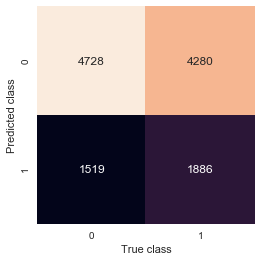

In [122]:
sns.heatmap(con_mat.T, 
            square=True, 
            annot=True, 
            fmt='d', 
            cbar=False,
            xticklabels=[0, 1], 
            yticklabels=[0, 1])

plt.xlabel('True class')
plt.ylabel('Predicted class');

Classification report

In [123]:
from sklearn.metrics import classification_report
print(classification_report(ytest, ypred))

             precision    recall  f1-score   support

          0       0.52      0.76      0.62      6247
          1       0.55      0.31      0.39      6166

avg / total       0.54      0.53      0.51     12413



ROC curve score

In [124]:
from sklearn.metrics import roc_auc_score
roc_auc_score(ytest, ypred)

0.5313570948696957

### Naive Bayes

In [125]:
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB()
gnb.fit(Xtrain, ytrain)
ypred = gnb.predict(Xtest)

Accuracy

In [126]:
from sklearn.metrics import accuracy_score
accuracy_score(ytest, ypred)

0.5848707000725046

Confusion matrix

In [127]:
from sklearn.metrics import confusion_matrix
con_mat = confusion_matrix(ytest, ypred)

In [128]:
con_mat

array([[2783, 3464],
       [1689, 4477]])

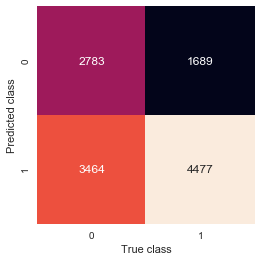

In [129]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()

sns.heatmap(con_mat.T, square=True, annot=True, fmt='d', cbar=False,
           xticklabels=[0, 1], 
           yticklabels=[0, 1])
plt.xlabel('True class')
plt.ylabel('Predicted class');

Classification report

In [130]:
from sklearn.metrics import classification_report
print(classification_report(ytest, ypred))

             precision    recall  f1-score   support

          0       0.62      0.45      0.52      6247
          1       0.56      0.73      0.63      6166

avg / total       0.59      0.58      0.58     12413



ROC curve score

In [131]:
from sklearn.metrics import roc_auc_score
roc_auc_score(ytest, ypred)

0.5857861660071048

### Logistic regression

In [132]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()
lr.fit(Xtrain, ytrain)
ypred = lr.predict(Xtest)

Accuracy

In [133]:
from sklearn.metrics import accuracy_score
accuracy_score(ytest, ypred)

0.5884959316845243

Confusion matrix

In [134]:
from sklearn.metrics import confusion_matrix
con_mat = confusion_matrix(ytest, ypred)
con_mat

array([[4012, 2235],
       [2873, 3293]])

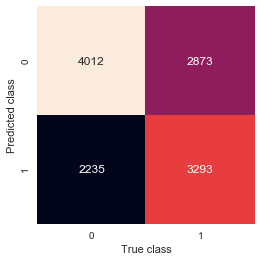

In [135]:
sns.heatmap(con_mat.T, square=True, annot=True, fmt='d', cbar=False,
           xticklabels=[0, 1], 
           yticklabels=[0, 1])
plt.xlabel('True class')
plt.ylabel('Predicted class');

Classification report

In [136]:
print(classification_report(ytest, ypred))

             precision    recall  f1-score   support

          0       0.58      0.64      0.61      6247
          1       0.60      0.53      0.56      6166

avg / total       0.59      0.59      0.59     12413



ROC curve score

In [137]:
from sklearn.metrics import roc_auc_score
roc_auc_score(ytest, ypred)

0.5881430027704249

### Random Forest

In [138]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier()
rf.fit(Xtrain, ytrain)
ypred = rf.predict(Xtest)

Accuracy

In [139]:
from sklearn.metrics import accuracy_score
accuracy_score(ytest, ypred)

0.6332876822685893

Confusion matrix

In [140]:
from sklearn.metrics import confusion_matrix
con_mat = confusion_matrix(ytest, ypred)
con_mat

array([[4493, 1754],
       [2798, 3368]])

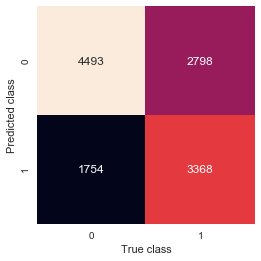

In [141]:
sns.heatmap(con_mat.T, square=True, annot=True, fmt='d', cbar=False,
           xticklabels=[0, 1], 
           yticklabels=[0, 1])
plt.xlabel('True class')
plt.ylabel('Predicted class');

Classification report

In [142]:
from sklearn.metrics import classification_report
print(classification_report(ytest, ypred))

             precision    recall  f1-score   support

          0       0.62      0.72      0.66      6247
          1       0.66      0.55      0.60      6166

avg / total       0.64      0.63      0.63     12413



ROC curve score

In [143]:
from sklearn.metrics import roc_auc_score
roc_auc_score(ytest, ypred)

0.632723220606806

#### Adaboost

In [144]:
from sklearn.ensemble import AdaBoostClassifier
abc = AdaBoostClassifier(n_estimators=100)
abc.fit(Xtrain, ytrain)
ypred = abc.predict(Xtest)

Accuracy

In [145]:
accuracy_score(ytest, ypred)

0.6849270925642471

Confusion matrix

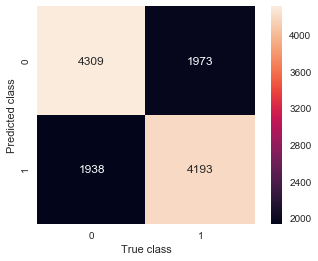

In [146]:
con_mat = confusion_matrix(ytest, ypred)
sns.heatmap(con_mat.T, 
            square=True, 
            annot=True, 
            fmt='d', 
            cbar=True,
            xticklabels=[0, 1], 
            yticklabels=[0, 1])

plt.xlabel('True class')
plt.ylabel('Predicted class')
plt.show()

Classification report

In [147]:
from sklearn.metrics import classification_report
print(classification_report(ytest, ypred))

             precision    recall  f1-score   support

          0       0.69      0.69      0.69      6247
          1       0.68      0.68      0.68      6166

avg / total       0.68      0.68      0.68     12413



ROC curve score

In [148]:
roc_auc_score(ytest, ypred)

0.6848952758433358

#### GBT

In [149]:
from sklearn.ensemble import GradientBoostingClassifier
gbc = GradientBoostingClassifier()
gbc.fit(Xtrain, ytrain)
ypred = gbc.predict(Xtest)

Accuracy

In [150]:
accuracy_score(ytest, ypred)

0.6886328848787562

Confusion matrix

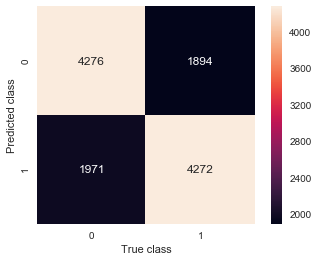

In [151]:
con_mat = confusion_matrix(ytest, ypred)

sns.heatmap(con_mat.T, 
            square=True, 
            annot=True, 
            fmt='d', 
            cbar=True,
            xticklabels=[0, 1], 
            yticklabels=[0, 1])

plt.xlabel('True class')
plt.ylabel('Predicted class');

Classification report

In [152]:
print(classification_report(ytest, ypred))

             precision    recall  f1-score   support

          0       0.69      0.68      0.69      6247
          1       0.68      0.69      0.69      6166

avg / total       0.69      0.69      0.69     12413



ROC scurve score

In [153]:
roc_auc_score(ytest, ypred)

0.6886601059913234

Feature importance

In [154]:
fi = pd.DataFrame({'variable': list(Xtrain.columns), 
                   'importance': gbc.feature_importances_})
fi = fi.sort_values(by='importance', ascending=False)
fi.tail()

,importance,variable
120,0.0,name_income_type_Student
121,0.0,name_income_type_Unemployed
128,0.0,name_family_status_Separated
129,0.0,name_family_status_Single / not married
117,0.0,name_income_type_Maternity leave


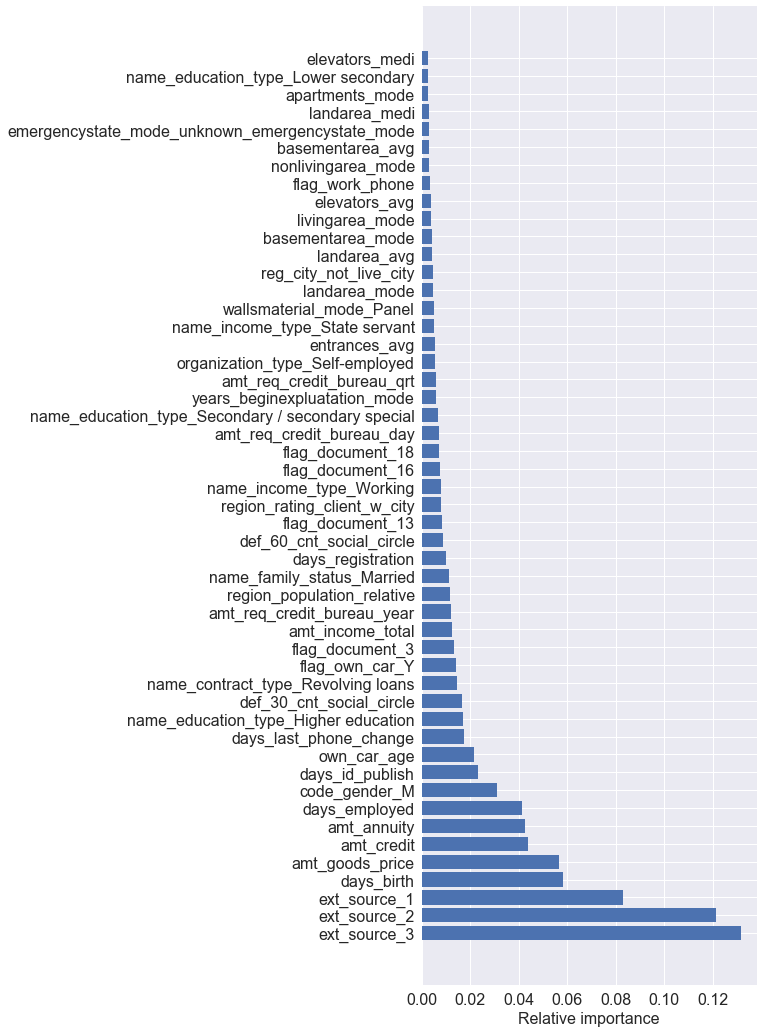

In [155]:
how_many = 50
plt.figure(figsize=(6,18))
plt.barh(range(how_many), fi['importance'].head(how_many))
plt.yticks(range(how_many), fi['variable'].head(how_many), size=16)
plt.xticks(size=16)
plt.xlabel('Relative importance', size=16)
plt.show()

## Hyperparameter tuning

In [156]:
from sklearn.model_selection import GridSearchCV

gbc = GradientBoostingClassifier()
param_grid = [{'learning_rate': [0.01, 0.1, 1.0]},
              {'n_estimators': [100, 200, 500, 1000]},
              {'max_depth': [1, 3, 5]}]

gs = GridSearchCV(gbc, 
                 param_grid,
                 cv=5,
                 scoring='f1')

gs.fit(Xtrain, ytrain)

GridSearchCV(cv=5, error_score='raise',
       estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid=[{'learning_rate': [0.01, 0.1, 1.0]}, {'n_estimators': [100, 200, 500, 1000]}, {'max_depth': [1, 3, 5]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='f1', verbose=0)

Best parameters

In [157]:
gs.best_params_

{'n_estimators': 200}

Best estimator

In [158]:
gs.best_estimator_

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=200,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False)

ROC score

In [159]:
model = gs.best_estimator_
model.fit(Xtrain, ytrain)
ypred = model.predict(Xtest)
roc_auc_score(ytest, ypred)

0.6916372989102885

In [4]:
roc_scores = [0.52, 0.57, 0.58, 0.63, 0.68, 0.79]
models = ['kNN', 'Naive Bayes', 'Logistic regression', 'Random forest', 'Gradient boosted \n decision trees', 'Light GBDT']
roc_scores.reverse()
models.reverse()

In [2]:
import matplotlib.pyplot as plt
% matplotlib inline
import seaborn as sns
sns.set()

/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


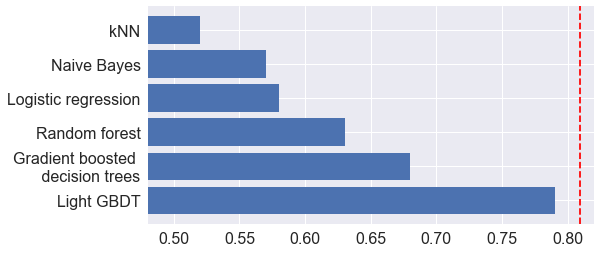

In [5]:
num_mod = len(models)
plt.figure(figsize=(8, 4))
plt.barh(range(num_mod), roc_scores, )
plt.yticks(range(num_mod), models, size=16)
plt.xticks(size=16)
plt.xlim(0.48, 0.82)
plt.axvline(x=0.809, 
            #label='Best score at Kaggle', 
            linestyle='--',
            c='r')

#plt.legend()
# plt.xlabel('Score', size=16)
plt.show();

In [ ]:
num_mod = len(models)
plt.figure(figsize=(8, 4))
plt.barh(range(num_mod), roc_scores)
plt.yticks(range(num_mod), models, size=16)
plt.xticks(size=16)
plt.xlim(0.48, 0.72)
#plt.legend()
# plt.xlabel('Score', size=16)
plt.show();

In [ ]:
import pandas as pd

In [ ]:
df_leader = pd.read_csv('home-credit-default-risk-publicleaderboard.csv')
df_leader.sample()

In [ ]:
df_leader['Score'].hist(bins=100, )
plt.xlim(0.48, 0.82)
plt.axvline(x=0.743, 
            #label='Best score at Kaggle', 
            linestyle='--',
            c='r')
plt.xticks(size=15)
plt.yticks(size=15);